# Summation Effects

Words, words, words.

In [69]:
from neurodsp.sim import sim_powerlaw
from neurodsp.spectral import compute_spectrum_welch

from fooof import FOOOF
from fooof.plts import plot_spectra

## Simulated Data

First, we'll check with simulated data on true 1/f signals that there is not an estimation

In [70]:
# Settings
n_seconds = 10
fs = 1000
exp = -2

In [71]:
sig = sim_powerlaw(n_seconds, fs, exp)

In [72]:
fm = FOOOF(max_n_peaks=0, verbose=False)

### Checking Number of Points per Segment

In [73]:
npersegs = [100, 500, 1000, 1500, 2000]

In [74]:
nseg_freqs = []
nseg_pows = []
for nperseg in npersegs:
    freqs, pows = compute_spectrum_welch(sig, fs, nperseg=nperseg)
    nseg_freqs.append(freqs)
    nseg_pows.append(pows)

/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


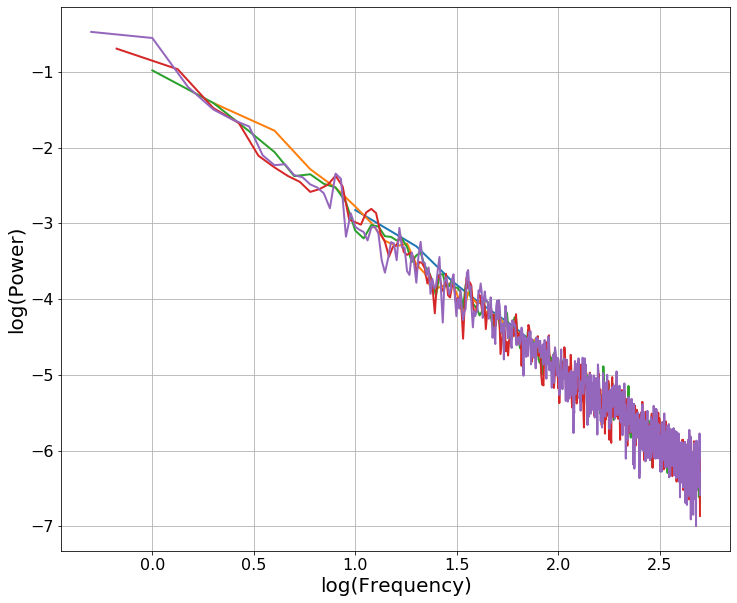

In [75]:
plot_spectra(nseg_freqs, nseg_pows, True, True)

In [76]:
for nperseg, freqs, pows in zip(npersegs, nseg_freqs, nseg_pows):
    fm.fit(freqs, pows)
    
    print('With nperseg of {:d} \tfit exponent is \t{:1.2f}'.format(\
        nperseg, fm.get_params('aperiodic_params', 'exponent')))

With nperseg of 100 	fit exponent is 	2.06
With nperseg of 500 	fit exponent is 	2.00
With nperseg of 1000 	fit exponent is 	2.00
With nperseg of 1500 	fit exponent is 	1.97
With nperseg of 2000 	fit exponent is 	1.99


### Checking Amount of Data Used

Next, ...

In [77]:
npoints = [250, 500, 1000, 2000, 5000, 10000]

In [78]:
npoint_freqs = []
npoint_pows = []
for npoint in npoints:
    freqs, pows = compute_spectrum_welch(sig[0:npoint], fs)
    npoint_freqs.append(freqs)
    npoint_pows.append(pows)

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 1000 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 1000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


/opt/anaconda3/lib/python3.7/site-packages/fooof/plts/spectra.py:48: RuntimeWarning: divide by zero encountered in log10
  plt_freqs = np.log10(freqs) if log_freqs else freqs


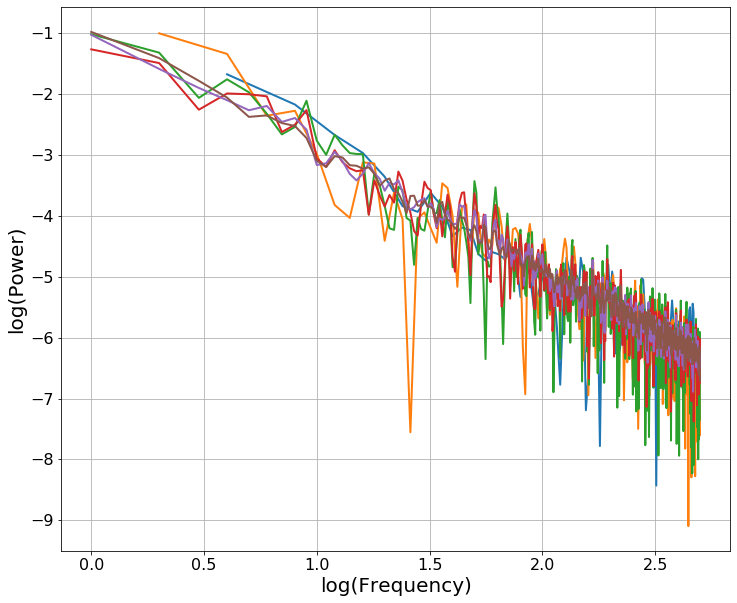

In [79]:
plot_spectra(npoint_freqs, npoint_pows, True, True)

In [80]:
for npoint, freqs, pows in zip(npoints, npoint_freqs, npoint_pows):
    fm.fit(freqs, pows)
    
    print('With n_points of {:d} \tfit exponent is \t{:1.2f}'.format(\
        npoint, fm.get_params('aperiodic_params', 'exponent')))

With n_points of 250 	fit exponent is 	2.06
With n_points of 500 	fit exponent is 	2.20
With n_points of 1000 	fit exponent is 	2.11
With n_points of 2000 	fit exponent is 	2.02
With n_points of 5000 	fit exponent is 	2.01
With n_points of 10000 	fit exponent is 	2.00


So far, we have used 

Since, we're using simulated


## Checking Real Data



In [ ]:
# ...
eeg_sig = np.load()

In [ ]:
# ...
meg_sig = np.load()

In [ ]:
# ..
ecog_sig = np.load()